## Prerequisites

In [13]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

import numpy as np

## MNIST Load & Check Data

In [6]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame=False)
mnist.keys()
# DESCR: Description about dataset
# data: Dataset, column: feature, sample: row
# Label: target

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
# 데이터 확인하기
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)
# X: 28*28(Fixel information)

(70000, 784) (70000,)


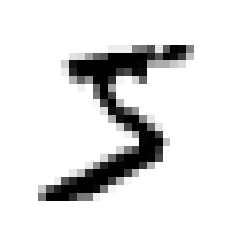

In [10]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, -1)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()
# cmap: Colormaps in Matplotlib
# Link: https://matplotlib.org/stable/tutorials/colors/colormaps.html

위의 그림은 5 같이 생겼는데, 실제로 5인지 확인

In [11]:
y[0] # Correct!

'5'

In [16]:
# Note that y[0]'s type: string
# We have to change string => int / use astype function
y = y.astype(np.uint8)
y[0]

5

In [29]:
# Dataset이 어떻게 구성되어 있는지 그려봅시다.
def plot_digit(data) :
    image = data.reshape(28, -1)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation='nearset')
    plt.axis("off")

def plot_digits(instances, images_per_row = 10, **options) :
    size = 28 # Pixel
    images_per_row = min(len(instances), images_per_row) # 만약 개수가 10개 이하면 한 줄에 10개가 아니라 그 개수만큼 위치시켜야함
    n_rows =  int(np.ceil(len(instances) / images_per_row)) # Ceil 처리, (len(instances)-1) // images_per_row + 1 과 동일 / np.ceil() returns float
    # n_rows =  np.ceil(len(instances) / images_per_row)

    # 아예 비워두기보다는 아무것도 없는 그림으로 채워넣는 것도 나쁘지 않습니다.
    n_empty = n_rows * images_per_row - len(instances)
    padded_instance = np.concatenate([instances, np.zeros((n_empty, size * size))], axis = 0)

     # 하나당 28*28인건 분명하고, 한 줄당 images_per_row개만큼 위치하므로 줄 수는 알아서 설정하도록 합시다.
    image_grid = padded_instance.reshape((-1, images_per_row, size, size))
    
    # column을 이루는 것들과 row를 이루는 것들끼리 묶어줍시다.
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    

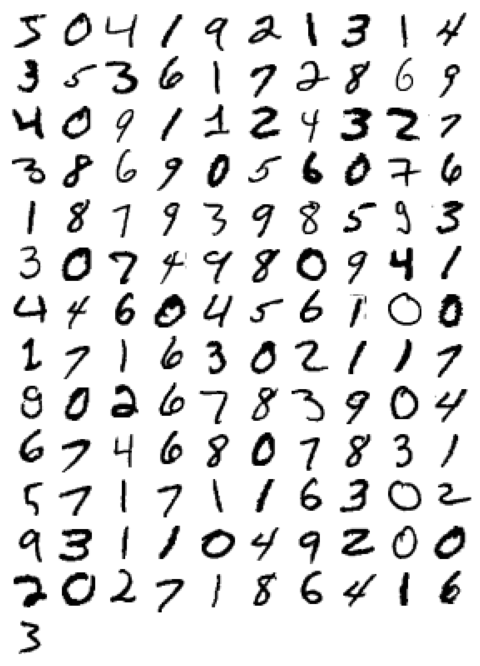

In [32]:
plt.figure(figsize = (12, 12))
example_images = X[:131]
plot_digits(example_images, images_per_row=10)
plt.show()

In [35]:
# Train, test split
from sklearn.model_selection import train_test_split

# 원래는 아래 코드를 써야 하나, MNIST Dataset은 이미 분해가 되어있기 때문에(...) 기준을 따라갑시다.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


## Binary Classification Traning

In [36]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

In [37]:
from sklearn.linear_model import SGDClassifier

# SGDClassifier => Stochastic gradient descent
sgd_clf = SGDClassifier(max_iter=100, tol = 1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_3)

C:\Users\SJH\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=100, random_state=42)

위에 이상한 warning이 떴는데.. 대충 눈치보니 iteration을 100번 돌려도 훈련이 덜 됐다라는거 같네요  
SGD 특성 상 빠른 만큼 많이 돌려도 될 것 같긴하죠  
1000번으로 바꿔보겠습니다.

In [38]:
sgd_clf = SGDClassifier(max_iter=1000, tol = 1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_3)

SGDClassifier(random_state=42)

In [43]:
print(sgd_clf.predict([some_digit, X[7], X[10]]))
# 맞게 나온거 같네요
# 실제로 8번째가 3이었으니 이를 넣어봅시다.

[False False  True]


쓰읍.. $100\%$는 아니니 그럴 수도 있지요

In [44]:
from sklearn.model_selection import cross_val_score


cross_val_score(sgd_clf, X_train, y_train_3, cv = 4, scoring = "accuracy")
# 96% 정도면 나쁘지 않네요

array([0.93433333, 0.9696    , 0.96093333, 0.964     ])

교차 검증을 활용하여 정확도를 측정해봅시다.

In [45]:
# KFold를 할 때 Dataset을 다섯조각으로 쪼갠 후에 해봅시다.
from sklearn import clone
from sklearn.model_selection import StratifiedKFold


skfolds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# StratifiedKFold.split: 쪼갤 때 train과 test index들을 제공합니다.
for train_index, test_index in skfolds.split(X_train, y_train_3) :
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_3[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_3[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    accur = sum(y_pred == y_test_folds)
    print(accur / len(y_pred))

0.9430833333333334
0.9653333333333334
0.9500833333333333
0.9649166666666666
0.9646666666666667


### 생각해볼 것
아래 코드의 의미를 파악해봅시다.  
Hint. fit 함수에서는 실제로 아무것도 하지 않고, predict에서는 모두 0인 array를 반환합니다. 과연 이가 의미하는 바가 무엇일까요?

In [46]:
from sklearn.base import BaseEstimator
class Never3Classifier(BaseEstimator) :
    def fit(self, X, y=None) :
        pass
    def predict(self, X) :
        return np.zeros((len(X), 1), dtype = bool)

never_3_clf = Never3Classifier()
cross_val_score(never_3_clf, X_train, y_train_3, cv = 5, scoring='accuracy')

array([0.89766667, 0.89508333, 0.89975   , 0.90008333, 0.8965    ])

## Confusion Matrix
Matrix 구성은 (실제 답, 모델의 예측 답)의 쌍으로 이루어져있다.  
즉, (1, 0)은 실제는 True이나 모델은 False로 예측했음을 의미  
보통 False는 $0$, True는 $1$임을 감안하여 Confusion Matrix도 그렇게 설계되어있음

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv = 5)

counfusion_matrix = confusion_matrix(y_true=y_train_3, y_pred=y_train_pred)
counfusion_matrix

array([[52096,  1773],
       [  993,  5138]], dtype=int64)

In [50]:
# 만일 완벽하게 fitting이 되었다면..

confusion_matrix(y_train_3, y_train_3)

array([[53869,     0],
       [    0,  6131]], dtype=int64)

### Note
* Def precision: TP / (TP + FP), 참이라고 분류한 것들 중에 실제로 참인 것(Positive 중 실제 True)  
* Def recall: TP / (TP + FN), 실제로 참인 것들 중에 참이라고 분류한 것(TP: True+Positive, FN: False + Negative)  
  
TP / FP / FN / FP에서..  
앞의 것은 실제 모델이 맞게 분류했는지, 뒤의 것은 모델이 어떻게 분류했는지를 의미  
즉, FP 같은 경우 모델은 잘못 분류했고 모델은 Positive, 즉 True로 예측했으므로 실제 답은 False, 예측 값은 True

In [52]:
from sklearn.metrics import precision_score


precision_score(y_train_3, y_train_pred)

0.7434524670814643

In [53]:
counfusion_matrix[1, 1] / (counfusion_matrix[0, 1] + counfusion_matrix[1, 1])

0.7434524670814643

In [54]:
from sklearn.metrics import recall_score


recall_score(y_train_3, y_train_pred)

0.8380362094274996

In [57]:
counfusion_matrix[1, 1] / (counfusion_matrix[1, 0] + counfusion_matrix[1, 1])

0.8380362094274996

#### Def F1 Score: Precision과 Recall의 조화평균

In [58]:
from sklearn.metrics import f1_score


f1_score(y_train_3, y_train_pred)

0.7879159638092317

In [59]:
prec = counfusion_matrix[1, 1] / (counfusion_matrix[0, 1] + counfusion_matrix[1, 1])
reca = counfusion_matrix[1, 1] / (counfusion_matrix[1, 0] + counfusion_matrix[1, 1])
2 * prec * reca / (prec + reca)

0.7879159638092317

## Recall-Precison Tradeoff
* Threshold: 임계점, 즉 이 수치보다 크면 True로, 작으면 False로 분류하겠다는 의미

In [63]:
y_scores = sgd_clf.decision_function([X[7], X[10]])
y_scores

array([-501.39324785, 1378.05599034])

In [74]:
for i in range(10) :
    threshold = 1000 * i
    print(f'threshold: {threshold:>4}, result:{y_scores > threshold}')

threshold:    0, result:[False  True]
threshold: 1000, result:[False  True]
threshold: 2000, result:[False False]
threshold: 3000, result:[False False]
threshold: 4000, result:[False False]
threshold: 5000, result:[False False]
threshold: 6000, result:[False False]
threshold: 7000, result:[False False]
threshold: 8000, result:[False False]
threshold: 9000, result:[False False]


In [76]:
from sklearn.metrics import precision_recall_curve


y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv = 5, method = 'decision_function')

precision, recall, threshold = precision_recall_curve(y_train_3, y_scores)

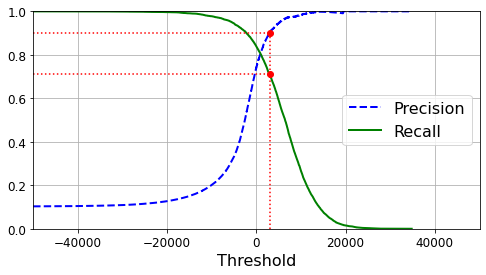

In [88]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recall[np.argmax(precision >= 0.90)] # argmax: 가장 큰 값의 Index를 반환(만약 같을 시 가장 빠른 index를 반환)
threshold_90_precision = threshold[np.argmax(precision >= 0.90)] # argmax: 가장 큰 값의 Index를 반환(만약 같을 시 가장 빠른 index를 반환)


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precision, recall, threshold)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

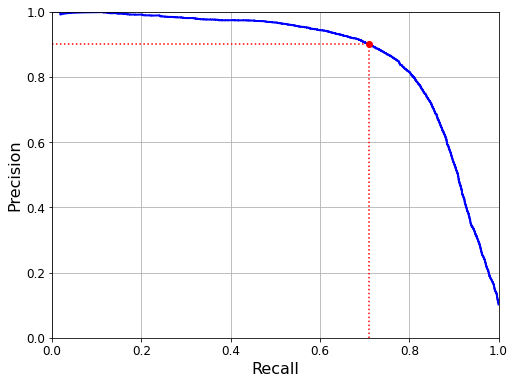

In [89]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precision, recall)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

## ROC Curve  
Def of ROC: $\dfrac{TPR}{FPR}$  
  
TPR: $\dfrac{TP}{TP+FN}$, FPR: $\dfrac{TN}{FP+TN}$

In [90]:
from sklearn.metrics import roc_curve


fpr, tpr, threshold = roc_curve(y_train_3, y_scores)

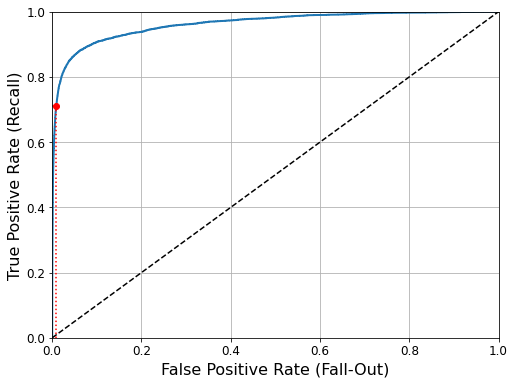

In [91]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown                                   # Not shown
plt.show()

## Multi-Layer Classification (Use one hot encoding)

In [92]:
from sklearn.svm import SVC


svm_clf = SVC(gamma = "auto", random_state=42)
svm_clf.fit(X_train[:10000], y_train[:10000])

SVC(gamma='auto', random_state=42)

In [93]:
svm_clf.predict([some_digit, X[7], X[10]])

array([5, 3, 3], dtype=uint8)

In [94]:
real_3_res = svm_clf.decision_function([X[10]])
print(real_3_res, np.argmax(real_3_res))

[[ 4.83847718  8.03753281  3.83118952  9.29958742  2.82378083 -0.22805216
   5.8488179   6.91484871  0.80335898  1.8224977 ]] 3


In [95]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### OvO or OVR 강제시키기

In [105]:
from sklearn.multiclass import OneVsRestClassifier


over_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
over_clf.fit(X_train[:1000], y_train[:1000])
over_clf.predict([some_digit, X[7], X[10]])

array([5, 3, 3], dtype=uint8)

In [106]:
len(over_clf.estimators_)

10

## 본격적으로 Training 하기

In [107]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit, X[7], X[10]])

array([3, 3, 3], dtype=uint8)

In [110]:
sgd_clf.decision_function([X[7]])

array([[-27610.27599699, -33782.62206322,  -6343.4343925 ,
          3756.25412024, -20423.1767938 ,  -9381.79838446,
        -61628.43623125, -28855.70780436,  -1274.70722219,
        -10145.68120048]])

In [111]:
cross_val_score(sgd_clf, X_train, y_train, cv = 5, scoring = "accuracy")

array([0.88083333, 0.88325   , 0.88116667, 0.86625   , 0.8875    ])

### Scaling!  (Precision Up)
* standscaler => Mean:0, Variance: 1

In [112]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 5, scoring='accuracy')

array([0.89733333, 0.88725   , 0.89583333, 0.89233333, 0.90516667])